In [980]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import json
np.bool = bool
import ptitprince #seaborn 0.11.0

In [981]:
RESULT_PATH = "immusign/final_evaluation/"
CONDITIONS = ["cll_dlbcl_hd", "nlphl_dlbcl_hd", "nlphl_dlbcl_hd_cll"]

In [982]:
MODELS = ["RandomForest", "LogisticRegression"]
MODEL_RESULTS = os.path.join(RESULT_PATH,CONDITION,"outputs_" +MODEL)

In [983]:
def load_model_results(results_path, condition, models, metric):
    results_df = pd.DataFrame()
    settings_df = pd.DataFrame()

    for model in models:
        model_path = os.path.join(results_path, condition,"outputs_" + model)
        model_settings = pd.DataFrame()
        model_results = pd.DataFrame()
        runs = []
        for path, subdirs, files in os.walk(model_path):
            output_identifier = os.path.basename(path)
            for name in files:
                file = os.path.join(path, name)
                if file.endswith("settings.json"):
                    with open(file) as f:
                        settings = f.read()
                        settings = settings.replace("\n", "").strip()
                        settings = json.loads(settings)

                        if len(model_settings) == 0:
                            model_settings = pd.DataFrame(settings, index=[0])
                        else:
                            model_settings = pd.concat([model_settings,  pd.DataFrame(settings, index=[0])], ignore_index=True)
                    runs.append(output_identifier)
                if file.endswith("performance.csv"):
                    results_ = pd.read_csv(file)
                    results_["run"] = output_identifier
                    results_["F1"] = 2 * (results_.precision * results_.recall) / (results_.precision + results_.recall)
                    results_["low_dlbcl_F1"] = 2 * (results_.low_dlbcl_precision * results_.low_dlbcl_recall) / (results_.low_dlbcl_precision + results_.low_dlbcl_recall)
                    if len(model_results) == 0:
                        model_results = results_
                    else:
                        model_results = pd.concat([model_results, results_], ignore_index = True)

        model_settings["run"] = runs
        model_settings["model"] = model
        if len(settings_df) == 0:
            settings_df = model_settings
            results_df = model_results
        else:
            results_df = pd.concat([results_df, model_results])
            settings_df = pd.concat([settings_df, model_settings])
    
    df = pd.DataFrame(np.repeat(settings_df.values, 3, axis=0))
    df.columns = settings_df.columns
    
    mean_validation_metric = []
    test_metric = []
    mean_validation_metric_low_dlbcl = []
    test_metric_low_dlbcl = []
    
    for i,row in settings_df.iterrows():
        run = row.run
        sub_df = results_df[results_df.run == run]
        if len(sub_df) == 0:
            mean_validation_metric += [np.nan,np.nan,np.nan]
            test_metric += [np.nan,np.nan,np.nan]
            mean_validation_metric_low_dlbcl += [np.nan,np.nan,np.nan]
            test_metric_low_dlbcl += [np.nan,np.nan,np.nan] 
        else:
            mean_validation_metric += list(sub_df[metric].iloc[0:3])
            test_metric += list(np.repeat(sub_df[metric].iloc[3],3)) 
            mean_validation_metric_low_dlbcl += list(sub_df["low_dlbcl_" + metric].iloc[0:3])
            test_metric_low_dlbcl += list(np.repeat(sub_df["low_dlbcl_" + metric].iloc[3],3)) 
    
    
    df["mean_validation_%s" % metric] = mean_validation_metric
    df["test_%s" % metric] = test_metric
    df["mean_validation_low_dlbcl_%s" % metric] = mean_validation_metric_low_dlbcl
    df["test_low_dlbcl_%s" % metric] = test_metric_low_dlbcl
    
    
    return df, results_df, settings_df

In [984]:
df_conditions = pd.DataFrame()
results_conditions_df = pd.DataFrame()
settings_conditions_df = pd.DataFrame()

for condition in CONDITIONS:
    df, results_df, settings_df = load_model_results(RESULT_PATH, condition, MODELS, "F1")
    df["condition"] = condition
    results_df["condition"] = condition
    settings_df["condition"] = condition
    
    df_conditions = pd.concat([df_conditions, df],ignore_index = True)
    results_conditions_df = pd.concat([results_conditions_df, results_df], ignore_index = True)
    settings_conditions_df = pd.concat([settings_conditions_df, settings_df],  ignore_index = True)

In [985]:
CONDITIONS

['cll_dlbcl_hd', 'nlphl_dlbcl_hd', 'nlphl_dlbcl_hd_cll']

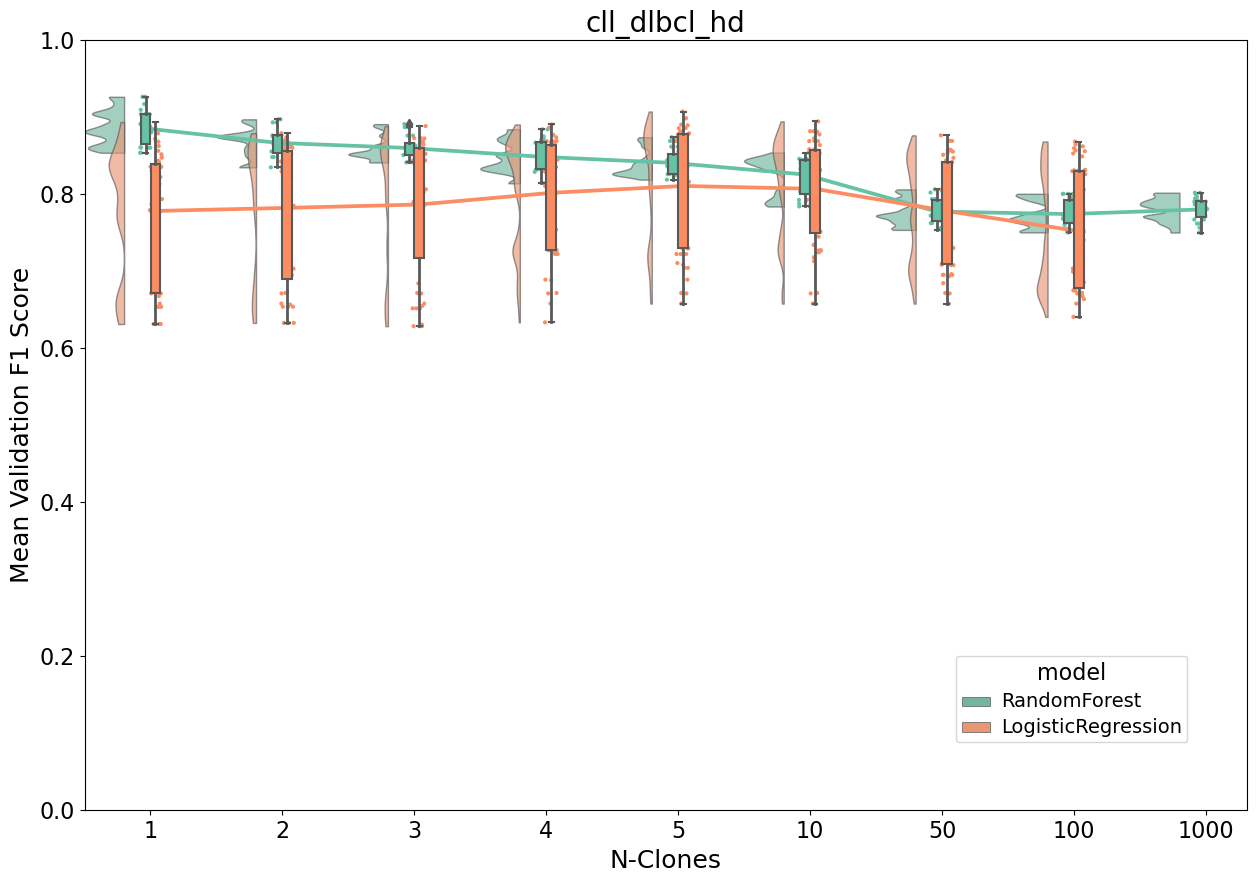

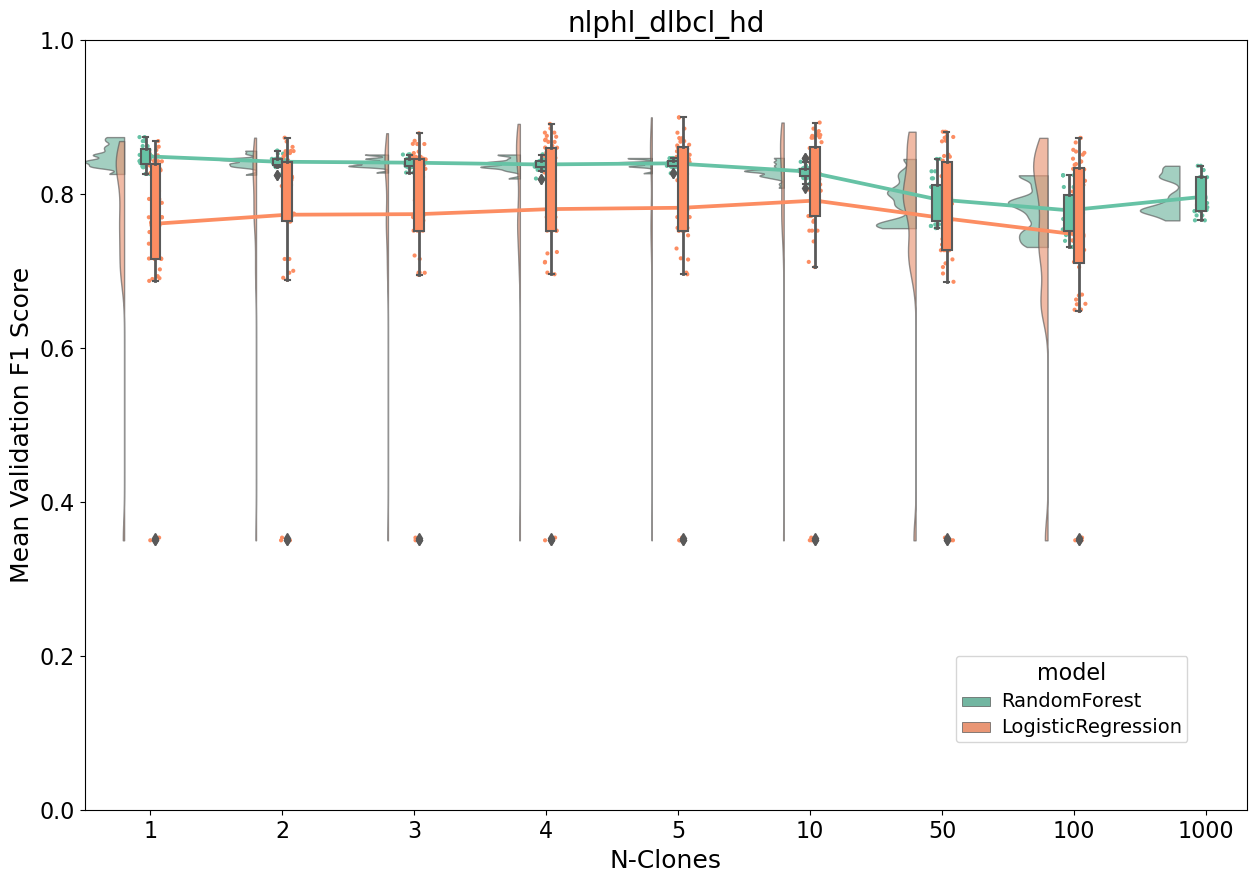

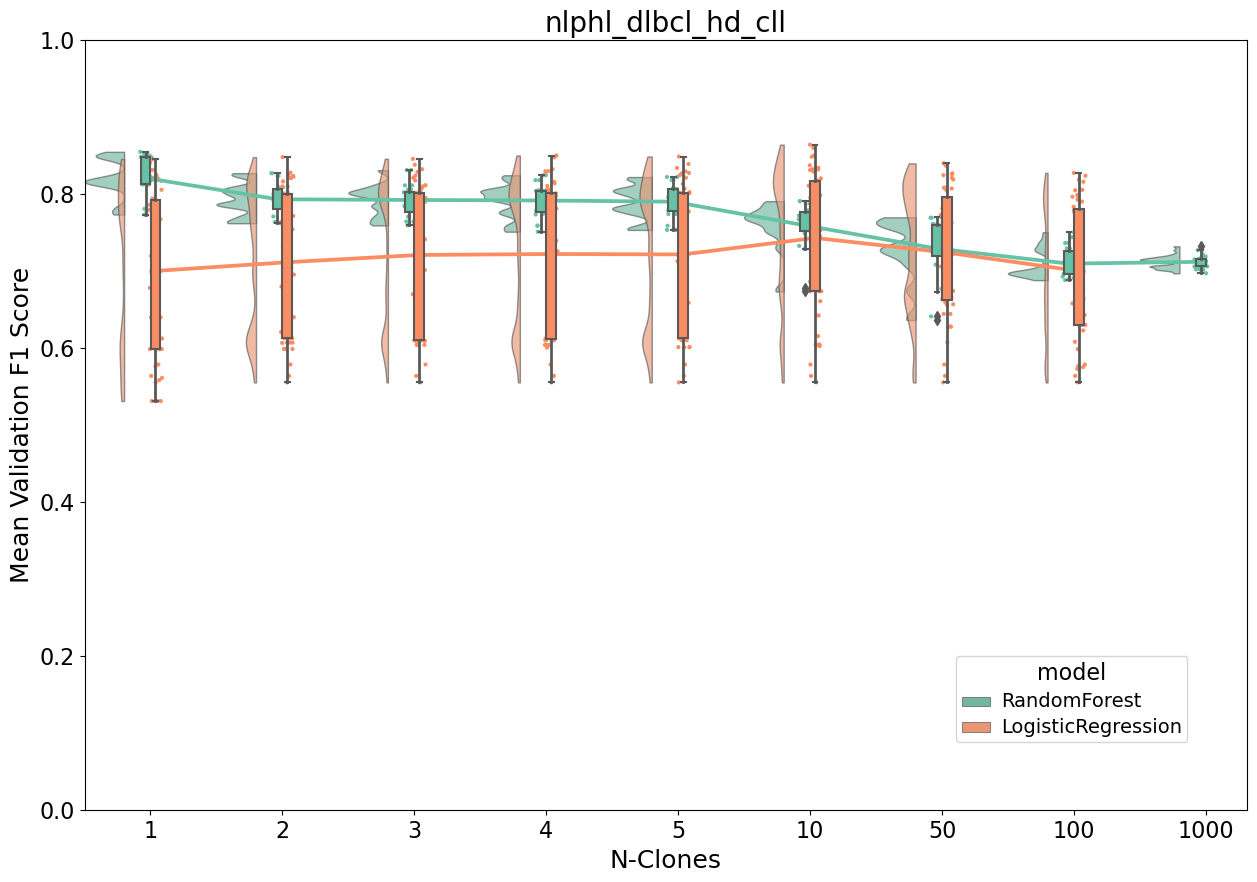

In [986]:
for condition in CONDITIONS:
    df = df_conditions[df_conditions.condition == condition]
    x_values = np.unique(df.n_clones)
    fig, ax = plt.subplots(figsize = (15,10))
    pt.RainCloud(x = "n_clones", y = "mean_validation_F1", data = df,
                     width_viol = .6, ax = ax, hue="model", pointplot = True, alpha = .65, dodge = True)
    ax.tick_params(axis='both', labelsize=16)
    ax.set_ylim(0,1)
    ax.set_ylabel("Mean Validation F1 Score",fontsize=18)
    ax.set_xlabel("N-Clones", fontsize=18)
    
    #title = 
    ax.set_title(condition,fontsize=20)

    legend = ax.get_legend()
    legend.get_title().set_fontsize(16)  
    for label in legend.get_texts():
        label.set_fontsize(14) 
    legend_position = legend.get_bbox_to_anchor().get_points()
    legend.set_bbox_to_anchor((0.75, 0, 0, 0.2))

In [987]:
best_models_per_clones = []

for condition in CONDITIONS:
    df = df_conditions[df_conditions.condition == condition]
    for i, group in df.groupby("n_clones"):
        group_reg = group[group.model == "LogisticRegression"]
        group_for = group[group.model == "RandomForest"]

        if len(group_reg) != 0:
            best_model_index = np.argmax(group_reg.mean_validation_F1)
            best_models_per_clones.append(group_reg.iloc[best_model_index:best_model_index+1].index[0])
        if len(group_for) != 0:
            best_model_index = np.argmax(group_for.mean_validation_F1)
            best_models_per_clones.append(group_for.iloc[best_model_index:best_model_index+1].index[0])

In [988]:
df_best = df_conditions.loc[best_models_per_clones]
df_best.sort_values(by="model", inplace=True, ascending=False)

/var/folders/lj/8f2m9cts7c1_dl0lwj330pyr0000gq/T/ipykernel_73317/2005768488.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reg.sort_values(by="n_clones", inplace=True)
/var/folders/lj/8f2m9cts7c1_dl0lwj330pyr0000gq/T/ipykernel_73317/2005768488.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_for.sort_values(by="n_clones", inplace=True)
/var/folders/lj/8f2m9cts7c1_dl0lwj330pyr0000gq/T/ipykernel_73317/2005768488.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([0] + list(x_values))


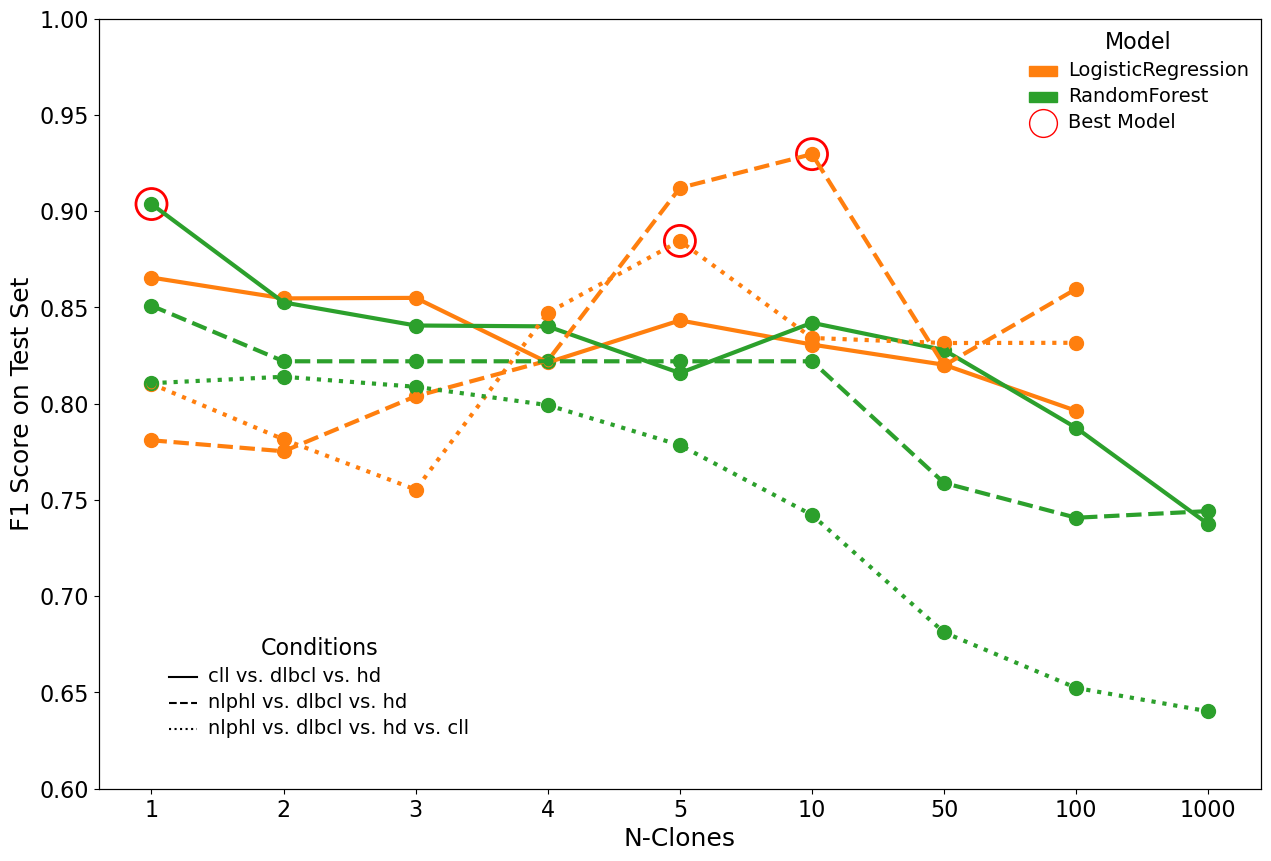

In [989]:
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
#markers = ["o", "s", "^"]
markers = ["o", "o", "o"]
lines = ["solid", "dashed", "dotted"]
#lines = ["solid", "solid", "solid"]

fig, ax = plt.subplots(figsize = (15,10))
for i, condition in enumerate(CONDITIONS):
    df = df_best[df_best.condition == condition]
    df_reg = df[df.model == "LogisticRegression"]
    df_for = df[df.model == "RandomForest"]
    
    df_reg.sort_values(by="n_clones", inplace=True)
    df_for.sort_values(by="n_clones", inplace=True)
    
    x_values = np.unique(df_reg.n_clones)
    ax.plot(range(len(x_values)), df_reg.test_F1, color = "C1", marker = markers[i], linestyle=lines[i],linewidth=3)
    ax.scatter(range(len(x_values)), df_reg.test_F1, color = "C1", marker = markers[i], s=100)
    
    x_values = np.unique(df_for.n_clones)
    ax.plot(range(len(x_values)), df_for.test_F1, color = "C2", marker = markers[i], linestyle=lines[i], linewidth=3)
    ax.scatter(range(len(x_values)), df_for.test_F1, color = "C2", marker = markers[i], s=100)
    
    if np.amax(df_for.test_F1) >= np.amax(df_reg.test_F1): 
        ax.scatter(np.argmax(df_for.test_F1), np.amax(df_for.test_F1), facecolor="None", edgecolor='red', linewidth=2, marker = markers[i], s=500)
    else:
        ax.scatter(np.argmax(df_reg.test_F1), np.amax(df_reg.test_F1), facecolor="None", edgecolor='red', linewidth=2, marker = markers[i], s=500)
    
ax.tick_params(axis='both', labelsize=16)
ax.set_ylim(0.6,1)
ax.set_ylabel("F1 Score on Test Set",fontsize=18)
ax.set_xlabel("N-Clones", fontsize=18)
ax.set_xlabel("N-Clones", fontsize=18)
ax.set_xticklabels([0] + list(x_values))

handles = [mpatches.Patch(color="C1", label="LogisticRegression"),
          mpatches.Patch(color="C2", label="RandomForest"), 
          mlines.Line2D([], [], marker = "o", markerfacecolor='None', markeredgecolor='red', markersize=20, ls='', label="Best Model")]


ax.legend(handles=handles, ncols=1, title = "Model", loc="upper right", frameon=False)
legend = ax.get_legend()
legend.get_title().set_fontsize(16)  
for label in legend.get_texts():
    label.set_fontsize(14)

ax2 = ax.twinx()
condition_handles = []
for i, condition in enumerate(CONDITIONS):
    #condition_handles.append(mlines.Line2D([], [], color="black", linestyle=lines[i], marker=markers[i], markersize=10, label=condition))
    condition_handles.append(mlines.Line2D([], [], color="black", linestyle=lines[i], marker=None, markersize=10, label=condition.replace("_", " vs. ")))

ax2.legend(handles=condition_handles, ncols=1, title = "Conditions", frameon=False, loc = "lower left")
ax2.set_yticks([])
legend = ax2.get_legend()
legend.get_title().set_fontsize(16)  
for label in legend.get_texts():
    label.set_fontsize(14)
legend_position = legend.get_bbox_to_anchor().get_points()
legend.set_bbox_to_anchor((0.05, 0.05, 0, 0))
plt.savefig('best_model_results.png', dpi=500)

/var/folders/lj/8f2m9cts7c1_dl0lwj330pyr0000gq/T/ipykernel_73317/2724102701.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reg.sort_values(by="n_clones", inplace=True)
/var/folders/lj/8f2m9cts7c1_dl0lwj330pyr0000gq/T/ipykernel_73317/2724102701.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_for.sort_values(by="n_clones", inplace=True)
/var/folders/lj/8f2m9cts7c1_dl0lwj330pyr0000gq/T/ipykernel_73317/2724102701.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([0] + list(x_values))


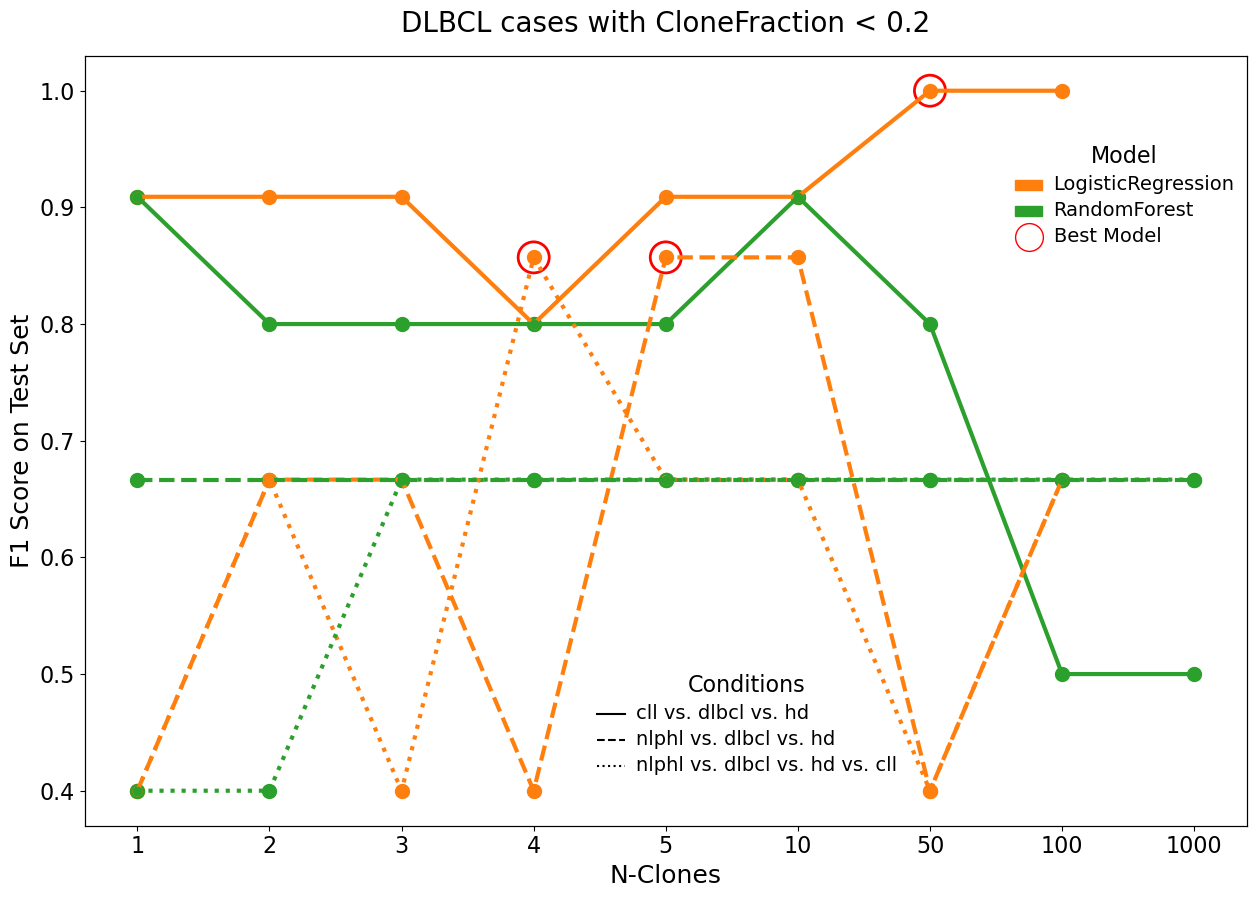

In [990]:
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
#markers = ["o", "s", "^"]
markers = ["o", "o", "o"]
lines = ["solid", "dashed", "dotted"]
#lines = ["solid", "solid", "solid"]

fig, ax = plt.subplots(figsize = (15,10))
for i, condition in enumerate(CONDITIONS):
    df = df_best[df_best.condition == condition]
    df_reg = df[df.model == "LogisticRegression"]
    df_for = df[df.model == "RandomForest"]
    
    df_reg.sort_values(by="n_clones", inplace=True)
    df_for.sort_values(by="n_clones", inplace=True)
    
    x_values = np.unique(df_reg.n_clones)
    ax.plot(range(len(x_values)), df_reg.test_low_dlbcl_F1, color = "C1", marker = markers[i], linestyle=lines[i],linewidth=3)
    ax.scatter(range(len(x_values)), df_reg.test_low_dlbcl_F1, color = "C1", marker = markers[i], s=100)
    
    x_values = np.unique(df_for.n_clones)
    ax.plot(range(len(x_values)), df_for.test_low_dlbcl_F1, color = "C2", marker = markers[i], linestyle=lines[i], linewidth=3)
    ax.scatter(range(len(x_values)), df_for.test_low_dlbcl_F1, color = "C2", marker = markers[i], s=100)
    
    if np.amax(df_for.test_low_dlbcl_F1) >= np.amax(df_reg.test_low_dlbcl_F1): 
        ax.scatter(np.argmax(df_for.test_low_dlbcl_F1), np.amax(df_for.test_low_dlbcl_F1), facecolor="None", edgecolor='red', linewidth=2, marker = markers[i], s=500)
    else:
        ax.scatter(np.argmax(df_reg.test_low_dlbcl_F1), np.amax(df_reg.test_low_dlbcl_F1), facecolor="None", edgecolor='red', linewidth=2, marker = markers[i], s=500)
    
ax.tick_params(axis='both', labelsize=16)
#ax.set_ylim(0.6,1)
ax.set_ylabel("F1 Score on Test Set",fontsize=18)
ax.set_xlabel("N-Clones", fontsize=18)
ax.set_xlabel("N-Clones", fontsize=18)
ax.set_xticklabels([0] + list(x_values))

handles = [mpatches.Patch(color="C1", label="LogisticRegression"),
          mpatches.Patch(color="C2", label="RandomForest"), 
          mlines.Line2D([], [], marker = "o", markerfacecolor='None', markeredgecolor='red', markersize=20, ls='', label="Best Model")]


ax.legend(handles=handles, ncols=1, title = "Model", loc="upper right", frameon=False)
legend = ax.get_legend()
legend.get_title().set_fontsize(16)  
for label in legend.get_texts():
    label.set_fontsize(14)
legend_position = legend.get_bbox_to_anchor().get_points()
legend.set_bbox_to_anchor((0.0, 0.0, 1, 0.9))    


ax2 = ax.twinx()
ax2.set_yticks([])
condition_handles = []
for i, condition in enumerate(CONDITIONS):
    #condition_handles.append(mlines.Line2D([], [], color="black", linestyle=lines[i], marker=markers[i], markersize=10, label=condition))
    condition_handles.append(mlines.Line2D([], [], color="black", linestyle=lines[i], marker=None, markersize=10, label=condition.replace("_", " vs. ")))

ax2.legend(handles=condition_handles, ncols=1, title = "Conditions", frameon=False, loc = "lower left")
legend = ax2.get_legend()
legend.get_title().set_fontsize(16)  
for label in legend.get_texts():
    label.set_fontsize(14)
legend_position = legend.get_bbox_to_anchor().get_points()
legend.set_bbox_to_anchor((0.43, 0.05, 0, 0))

ax.set_title("DLBCL cases with CloneFraction < 0.2",  fontsize=20, y=1.02)
plt.savefig('best_model_results_low_dlbcl.png', dpi=500)

# Best Model Parameter

In [991]:
best_models_per_condition = {}
for i, condition in enumerate(CONDITIONS):
    df = df_best[df_best.condition == condition]
    best_models_per_condition[condition] = list(df.iloc[np.argmax(df.test_F1)][["model", "run"]])

In [992]:
best_models_per_condition

{'cll_dlbcl_hd': ['RandomForest', 'output_Sep_06_113234_38HYF_classification'],
 'nlphl_dlbcl_hd': ['LogisticRegression',
  'output_Sep_06_111214_VFPTO_classification'],
 'nlphl_dlbcl_hd_cll': ['LogisticRegression',
  'output_Sep_06_134738_9J1IC_classification']}

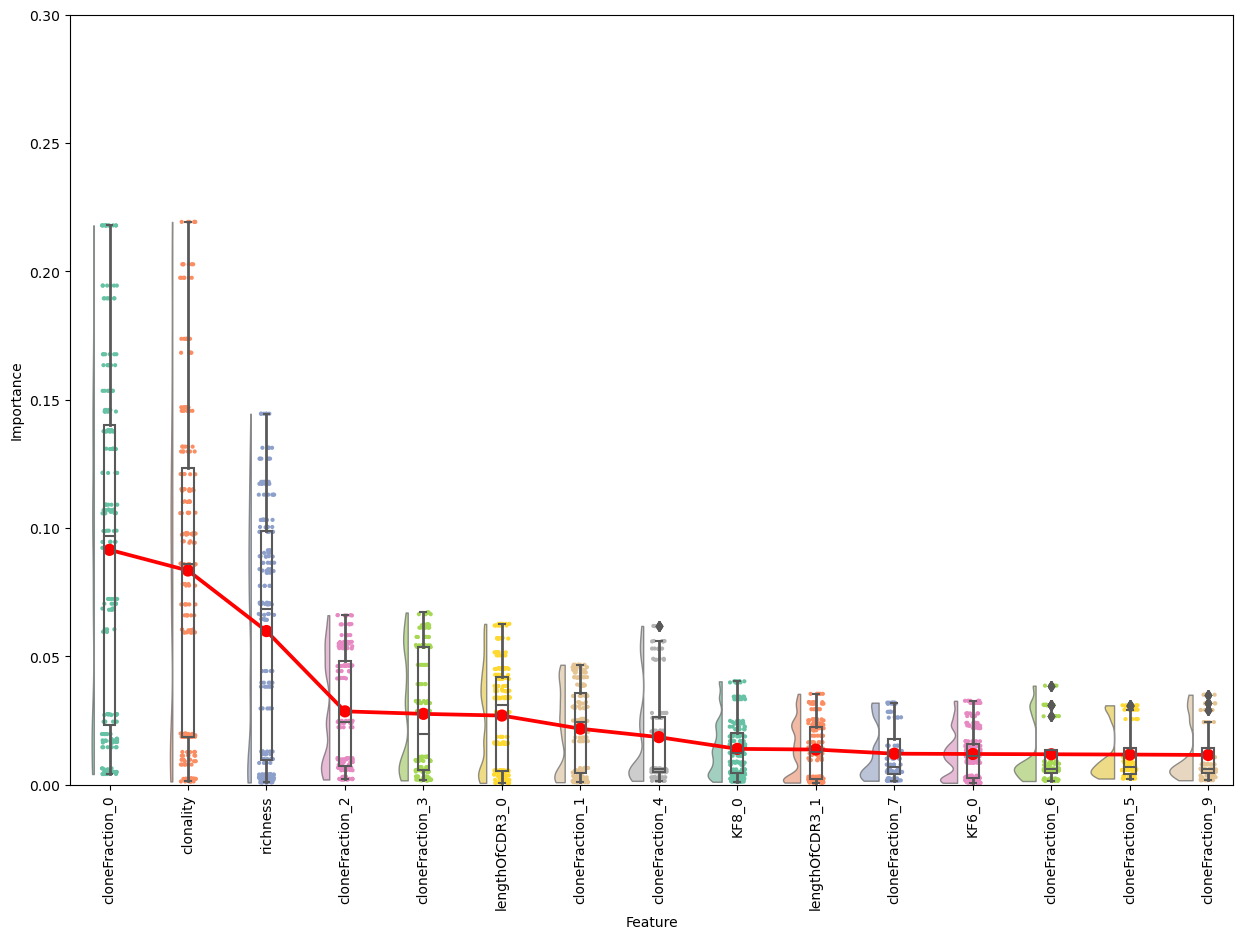

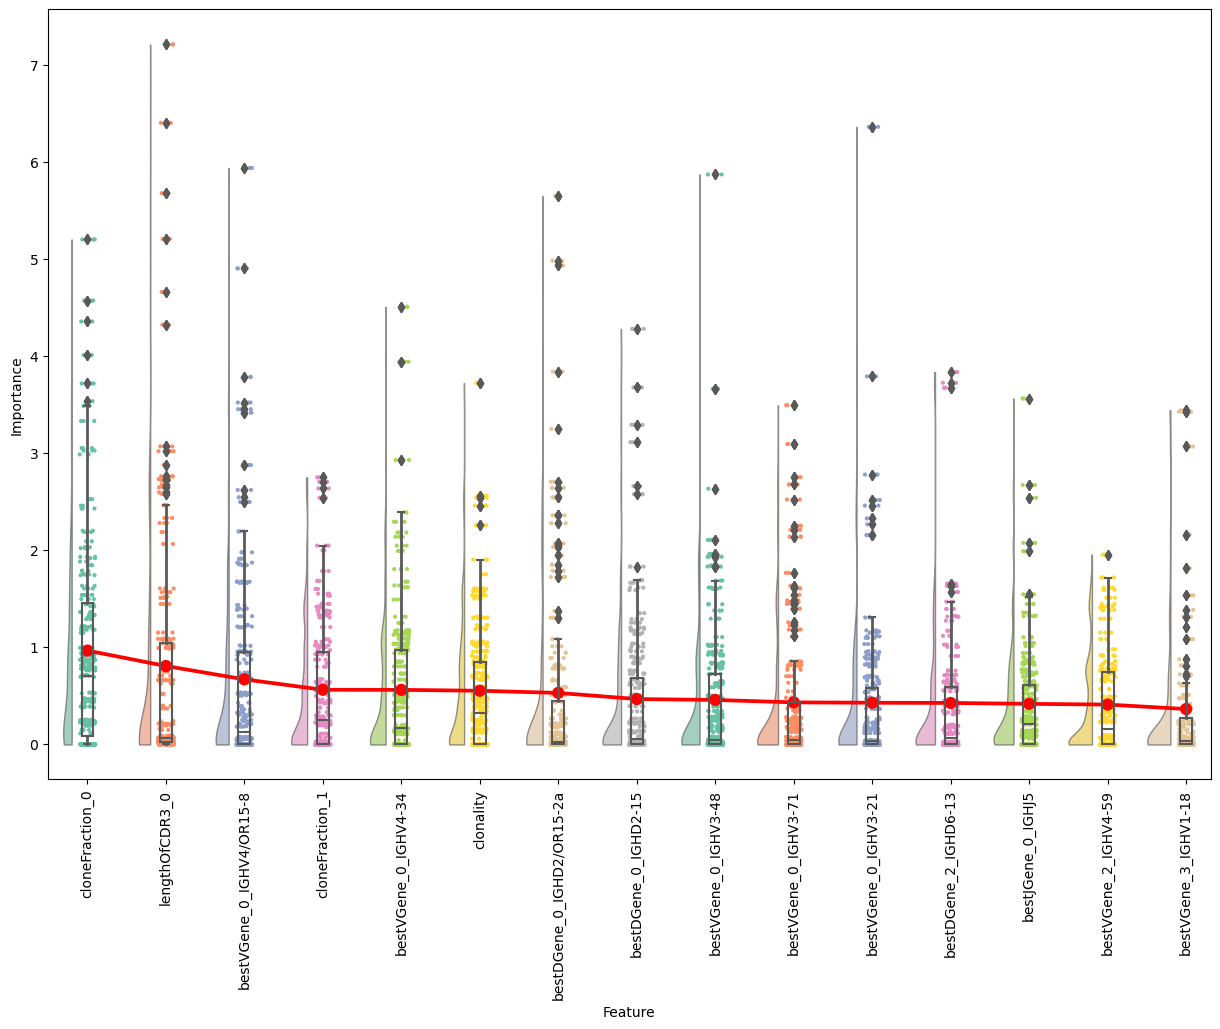

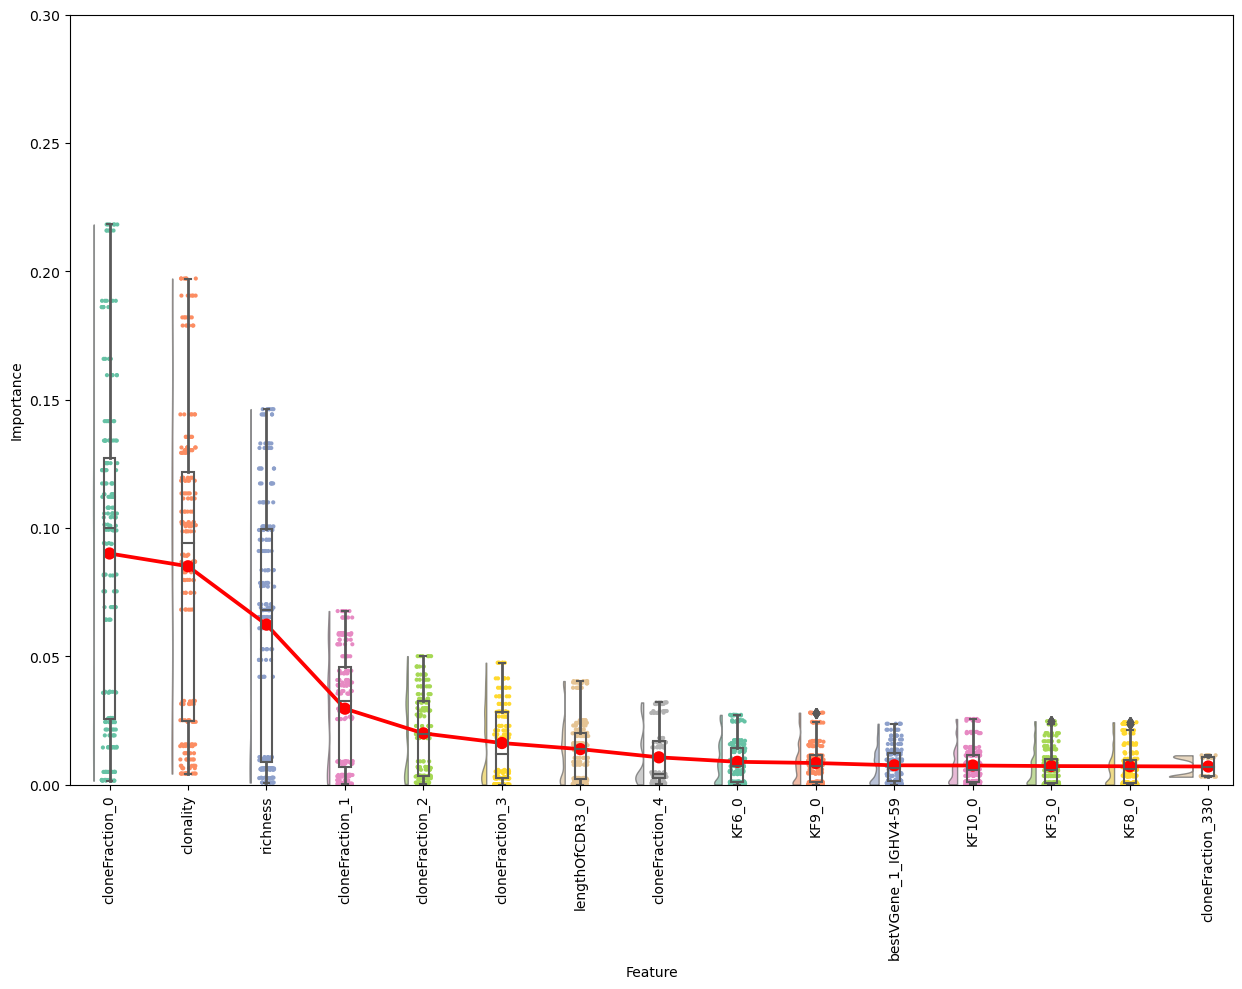

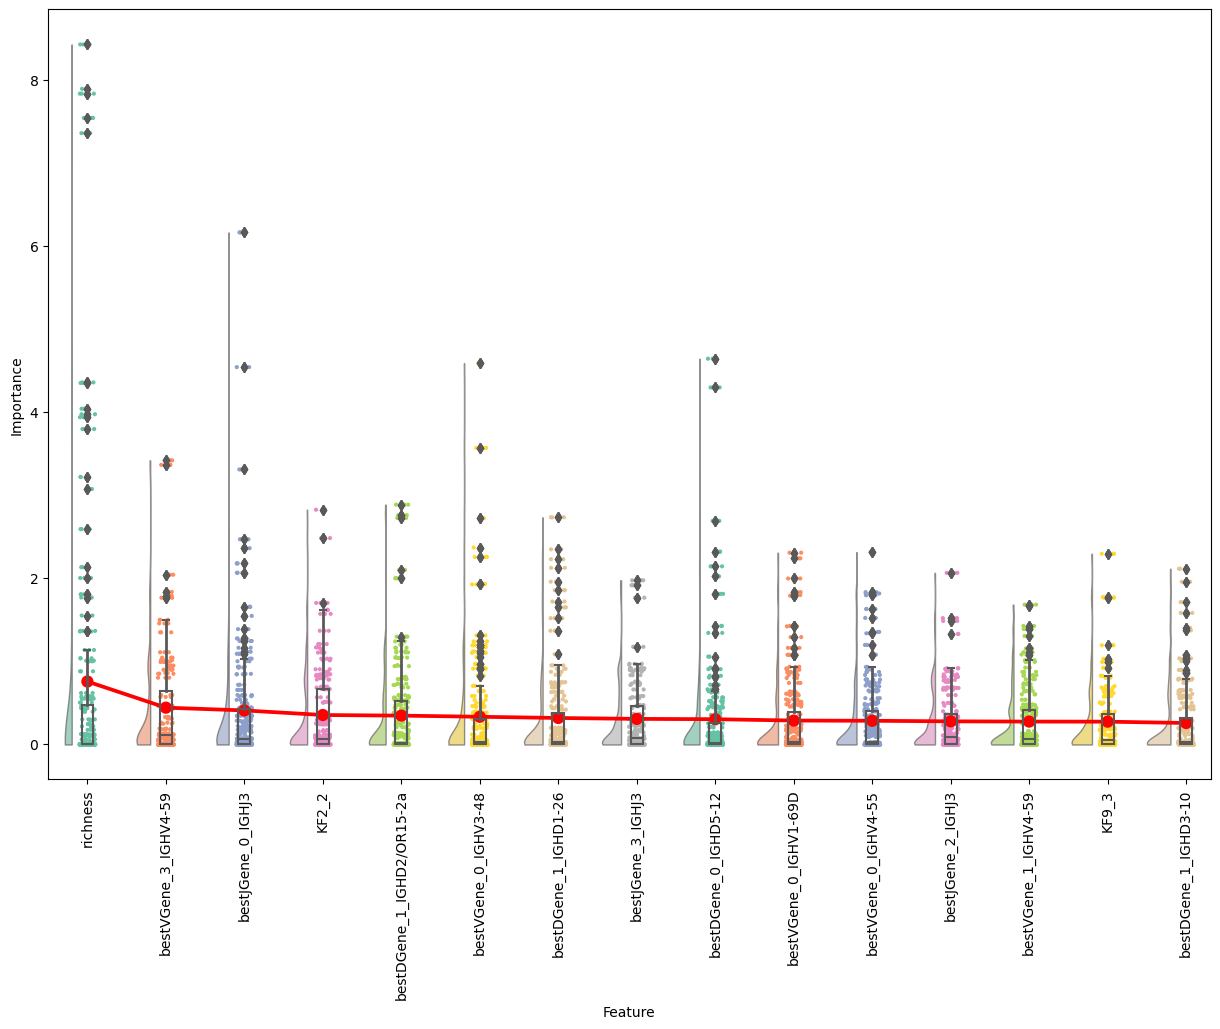

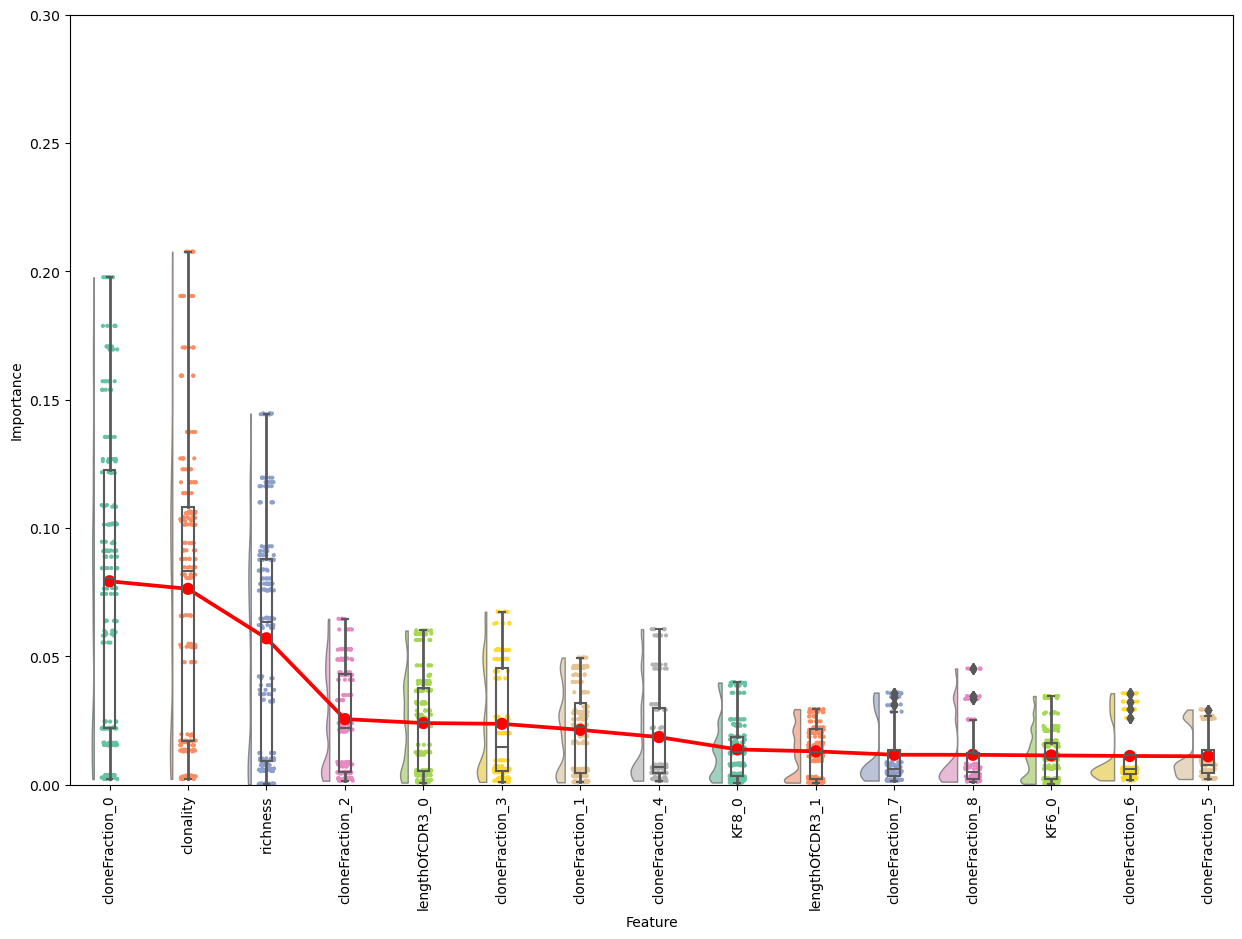

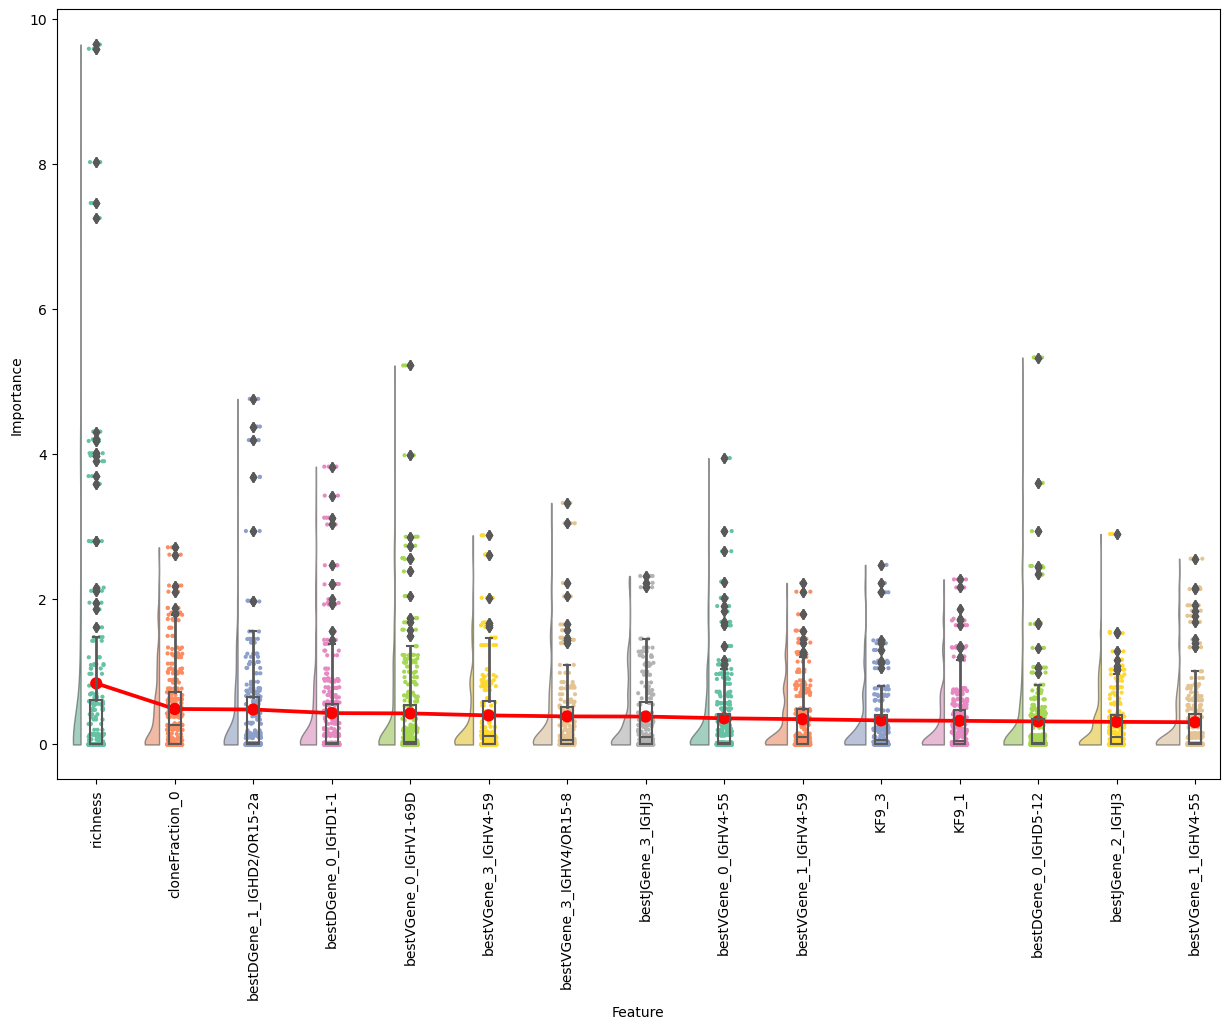

In [993]:
for condition in CONDITIONS:
    df = df_conditions[df_conditions.condition == condition]
    for model in ["RandomForest", "LogisticRegression"]:
        df_model = df[df.model==model]
        feature_importance_model = pd.DataFrame()
        for i, run in enumerate(df_model.run):
            path = os.path.join(RESULT_PATH,condition,"outputs_" +model, run, "feature_importances.json")
            try:
                with open(path) as f:
                    settings = f.read()
                    settings = settings.replace("\n", "").strip()
                    settings = json.loads(settings)
            except:
                continue
        
            feature_importance = pd.DataFrame({'Feature': list(settings.keys()), 'Importance': np.abs(list(settings.values()))})
            feature_importance_model = pd.concat([feature_importance_model,feature_importance]) 
    
        mean_feature_importance = feature_importance_model.groupby("Feature").mean().reset_index().sort_values(by="Importance",ascending=False)
        mean_feature_importance.rename(columns= {'Importance':'Mean_Importance'}, inplace=True)
        top_15_features = list(mean_feature_importance.Feature.iloc[0:15])

        fig, ax = plt.subplots(figsize = (15,10))
        sub_df = feature_importance_model[feature_importance_model.Feature.isin(top_15_features)]
        sub_df = sub_df.merge(mean_feature_importance, on="Feature")
        sub_df.sort_values(by = "Mean_Importance", inplace=True, ascending=False)
        pt.RainCloud(x = "Feature", y = "Importance", data = sub_df,
                         width_viol = .6, ax = ax, pointplot = True, alpha = .65, dodge = True)
        if model == "RandomForest":
            ax.set_ylim((0,0.3))
        ax.tick_params(axis='x', rotation=90)
        

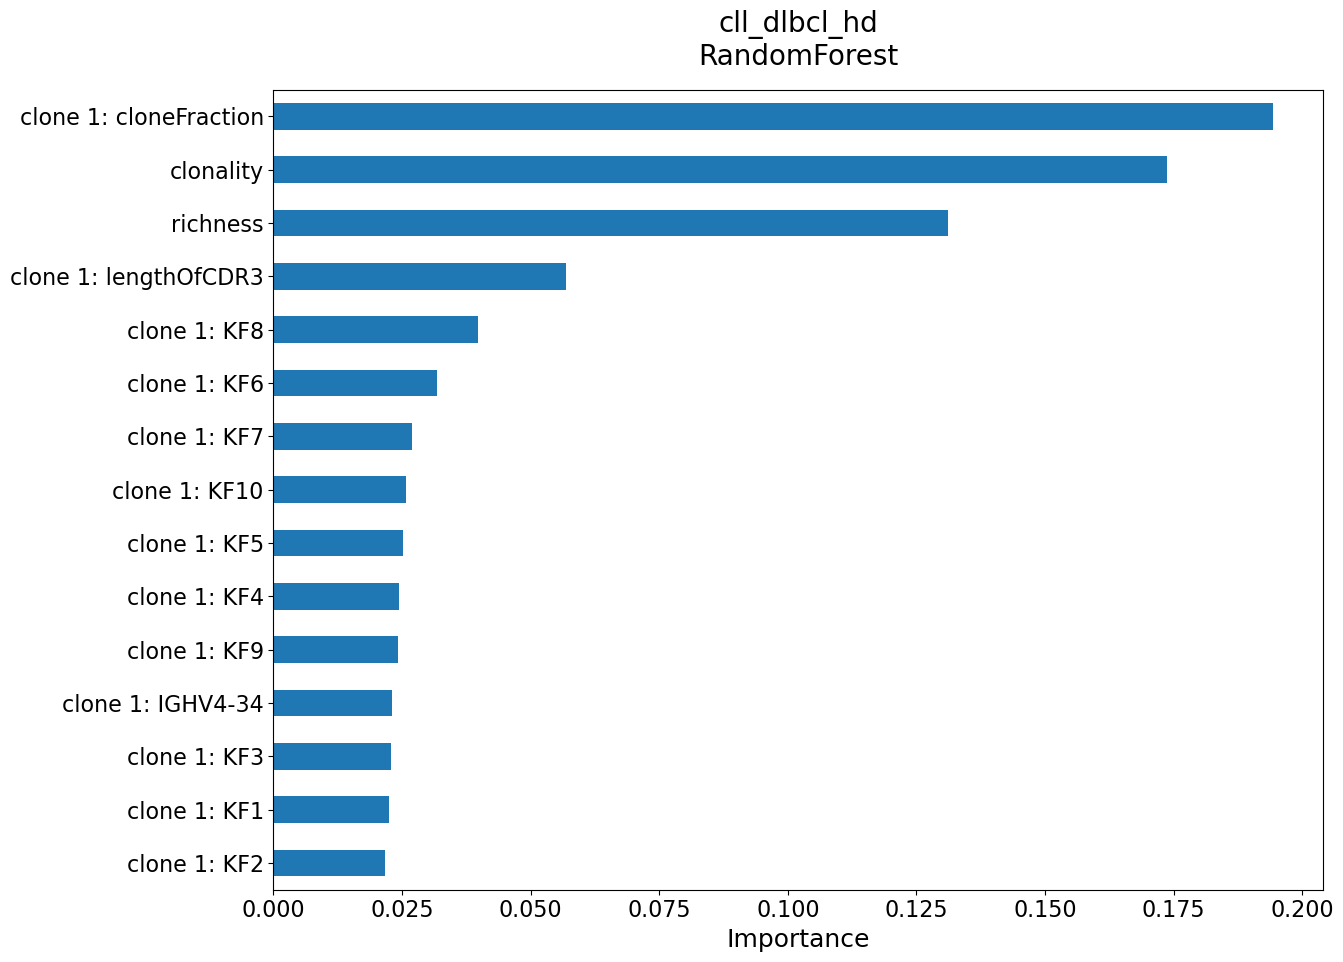

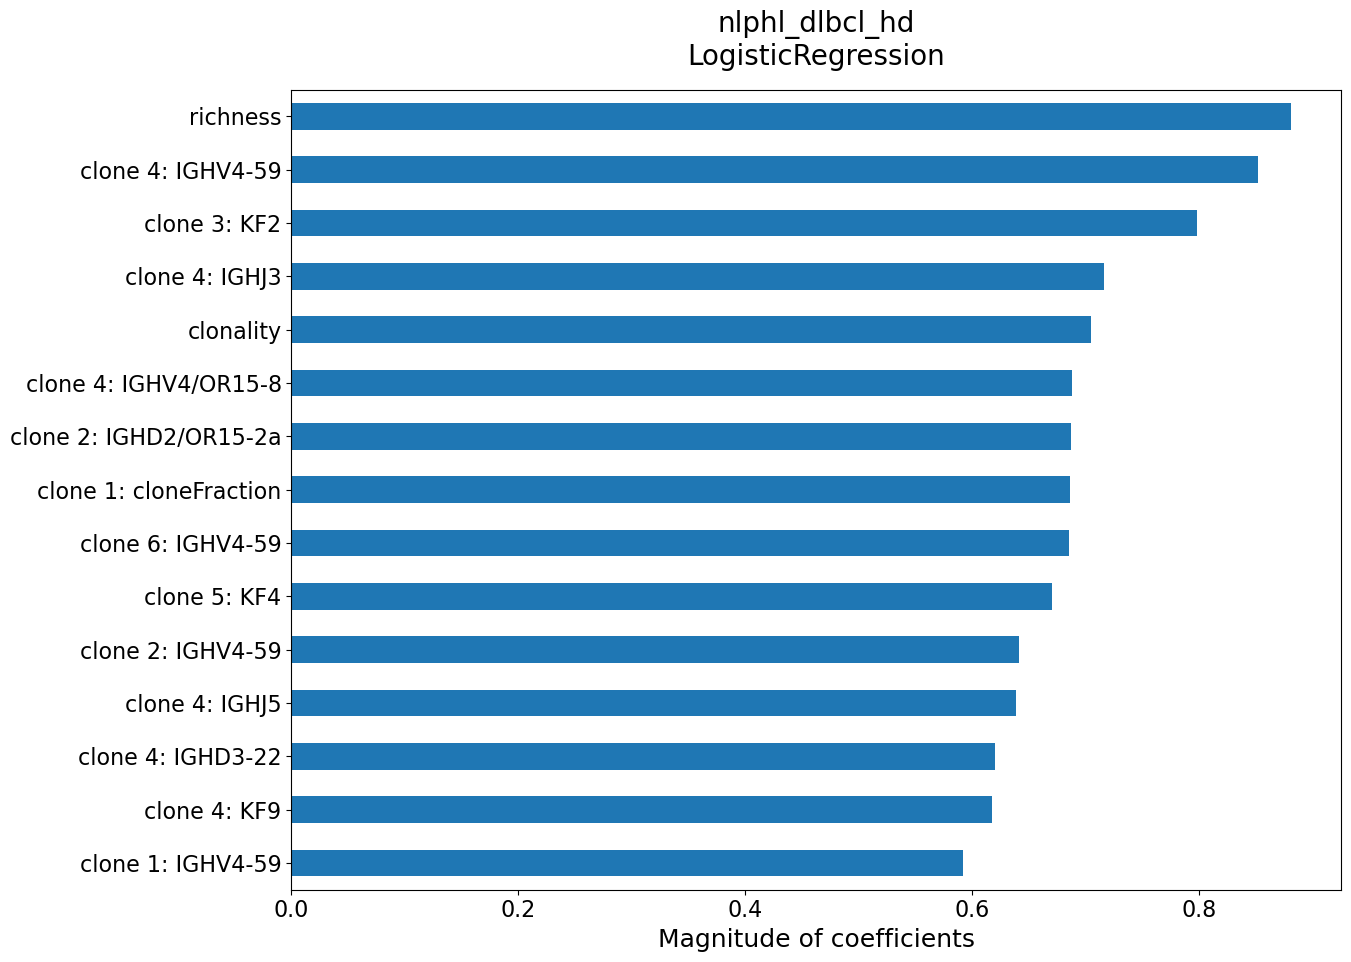

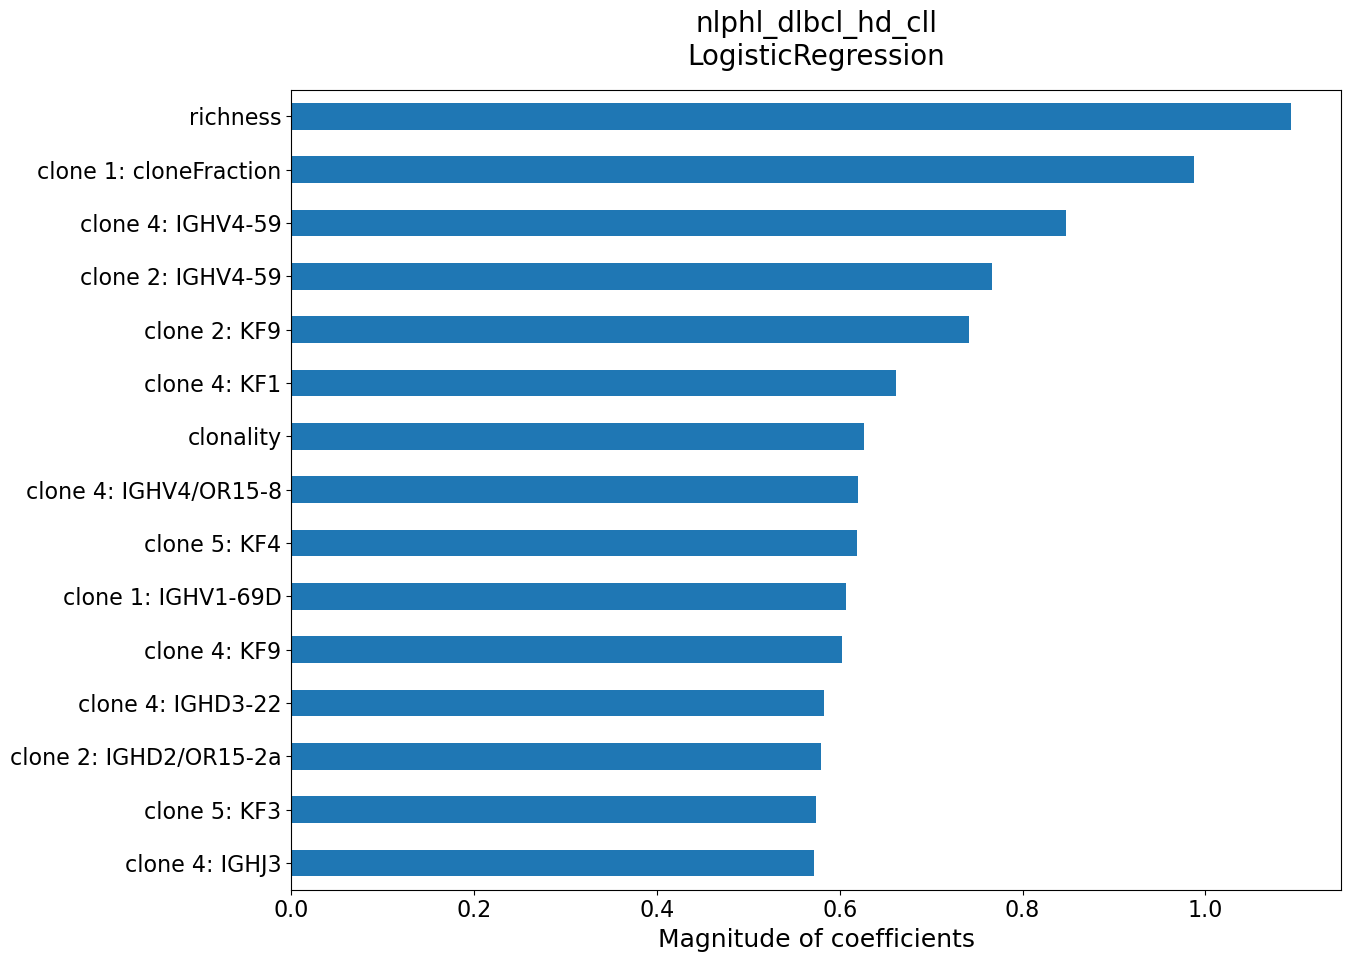

In [1203]:
best_feature_importance_df = pd.DataFrame()
for condition in best_models_per_condition:
    model = best_models_per_condition[condition][0]
    run = best_models_per_condition[condition][1]
    path = os.path.join(RESULT_PATH,condition,"outputs_" +model, run, "feature_importances.json")
    with open(path) as f:
        settings = f.read()
        settings = settings.replace("\n", "").strip()
        settings = json.loads(settings)
        
    
    fig, ax = plt.subplots(figsize=(15,10))
    feature_importance = pd.DataFrame({'Feature': list(settings.keys()), 'Importance': np.abs(list(settings.values()))})
    feature_importance = feature_importance.sort_values('Importance', ascending=True)
    feature_importance.iloc[-15:].plot(x='Feature', y='Importance', kind='barh', ax=ax )   
    ax.get_legend().remove()
    
    
    new_ticks = []
    for tick in ax.get_yticklabels():
        tick_text = tick.get_text()
        if "_" in tick_text:
            splitted = tick_text.split("_")
            clone = int(splitted[1]) + 1
            splitted = np.delete(splitted, 1)
            new_tick = "clone %s: " % clone + splitted[-1]#" ".join(splitted)             
            new_ticks.append(new_tick)
        else:
            new_ticks.append(tick_text)
    ax.set_yticklabels(list(new_ticks))
    ax.tick_params(axis='both', labelsize=16)
    ax.set_ylabel("",fontsize=18)
    if model == "RandomForest":
        ax.set_xlabel("Importance", fontsize=18)
    else:
        ax.set_xlabel("Magnitude of coefficients", fontsize=18)
    ax.set_title(condition + "\n" + model,  fontsize=20, y=1.02)
    plt.subplots_adjust(left=0.2, right=0.9, top=0.9, bottom=0.1)
    plt.savefig('features_%s.png' % condition, dpi=500)
    
    feature_importance["condition"] = condition
    best_feature_importance_df = pd.concat([best_feature_importance_df, feature_importance])

# PCA

In [976]:
import utils
from sklearn.decomposition import PCA
from utils import contaminated_hds
from sklearn.preprocessing import StandardScaler

In [953]:
data = utils.load_clone_files_data("/Users/labadmin/Projects/immusign/immusign/data/clones_mit_kidera")
data = data[data.bestVGene.apply(lambda x: "IGH" in x)]
data = data[~data["clones.txt.name"].isin(contaminated_hds)]
data.sort_values(["clones.txt.name", "cloneFraction"], ascending= [True, False], inplace =True)
data["richness"] = data["#aminoacid_clonotypes"]

In [956]:
data_meta = pd.read_csv("immusign/data/lymphoma-reps-file-infos.csv")
data = data.merge(data_meta, on = "clones.txt.name")

In [1199]:
cond_lymphom_dict = {'cll_dlbcl_hd': ["cll", "dlbcl", "gcb_dlbcl", "abc_dlbcl", "hd"],
                    'nlphl_dlbcl_hd': ["nlphl", "dlbcl", "gcb_dlbcl", "abc_dlbcl", "hd"],
                    'nlphl_dlbcl_hd_cll': ["nlphl", "dlbcl", "gcb_dlbcl", "abc_dlbcl", "hd", "cll"]}

In [1198]:
for condition in CONDITIONS:
    data_condition = data[data.lymphoma_specification.isin(cond_lymphom_dict[condition])
    top_15_feature_importance = best_feature_importance_df[best_feature_importance_df["condition"] == condition].iloc[:-15][::-1]
                          

['cll_dlbcl_hd', 'nlphl_dlbcl_hd', 'nlphl_dlbcl_hd_cll']

In [1208]:
best_feature_importance_df[best_feature_importance_df["condition"] == condition].iloc[-15:][::-1]

,Feature,Importance,condition
0,richness,1.094084,nlphl_dlbcl_hd_cll
1,cloneFraction_0,0.987266,nlphl_dlbcl_hd_cll
2,bestVGene_3_IGHV4-59,0.847327,nlphl_dlbcl_hd_cll
3,bestVGene_1_IGHV4-59,0.766316,nlphl_dlbcl_hd_cll
4,KF9_1,0.741359,nlphl_dlbcl_hd_cll
5,KF1_3,0.661506,nlphl_dlbcl_hd_cll
6,clonality,0.626093,nlphl_dlbcl_hd_cll
7,bestVGene_3_IGHV4/OR15-8,0.620262,nlphl_dlbcl_hd_cll
8,KF4_4,0.619013,nlphl_dlbcl_hd_cll
9,bestVGene_0_IGHV1-69D,0.606610,nlphl_dlbcl_hd_cll


In [1122]:
top_n = 1
data_top_n = data_condition[data_condition["cloneId"] == (top_n-1)]

In [1124]:
labels = data_top_n.lymphoma_specification.apply(lambda x: "dlbcl" if x in ["dlbcl", "gcb_dlbcl", "abc_dlbcl"] else x)

In [1126]:
data_top_n = data_top_n.iloc[np.argsort(labels)]
labels = labels.iloc[np.argsort(labels)]

In [1137]:
l, c = np.unique(labels, return_counts = True)

In [1176]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data_top_n[["richness", "clonality","cloneFraction"]])

In [1177]:
n_components = 2

pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)

principal_components = pca.components_

# Explained variance ratio for each component
explained_variance_ratio = pca.explained_variance_ratio_

In [1178]:
idxs = np.cumsum(c)
print(idxs)

[348 528 818]


In [1179]:
centroids = []
idxs = np.cumsum(c)
for i, idx in enumerate(idxs):
    if i == 0:
        centroids.append(np.median(X_pca[0:idx,:], axis=0))
    else:
        centroids.append(np.median(X_pca[idxs[i-1]:idx,:], axis=0))

In [1182]:
colors = []
for i in labels:
    if i == "cll":
        colors.append("C0")
    elif i == "dlbcl":
        colors.append("C1")
    else:
        colors.append("C2")

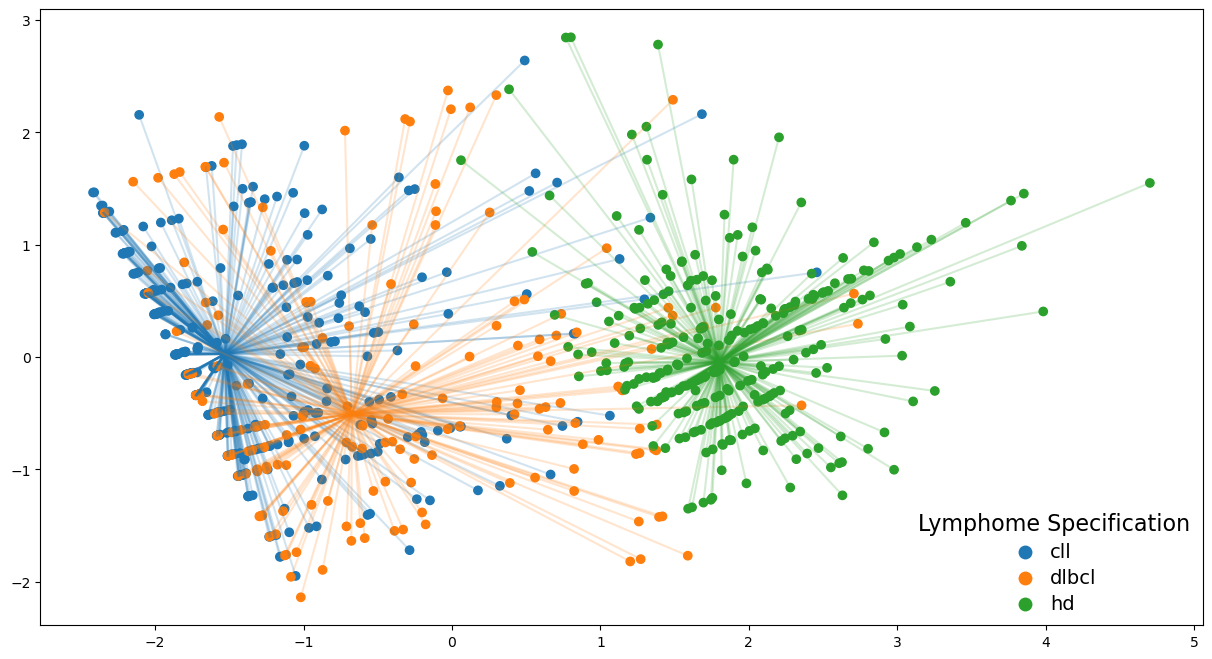

In [1197]:
fig, ax = plt.subplots(figsize=(15,8))
ax.scatter(X_pca[:,0],X_pca[:,1],color=colors)


centroids = []
idxs = np.cumsum(c)
for i, idx in enumerate(idxs):
    if i == 0:
        centroid = np.median(X_pca[0:idx,:], axis=0)
        centroids.append(centroid)
        
        x = X_pca[0:idx,0]
        y = X_pca[0:idx,1]
        
        for xx, yy, in zip(x, y):
            ax.plot([centroid[0], xx], [centroid[1], yy], color = "C%d" %i, alpha = 0.2)
    else:
        centroid = np.median(X_pca[idxs[i-1]:idx,:], axis=0)
        centroids.append(centroid)
        
        x = X_pca[idxs[i-1]:idx,0]
        y = X_pca[idxs[i-1]:idx,1]
        
        for xx, yy, in zip(x, y):
            ax.plot([centroid[0], xx], [centroid[1], yy], color = "C%d" %i, alpha = 0.2)


#for i, x in enumerate(centroids):
#    ax.scatter(x[0], x[1], s=200, color = "red", marker = "x", linewidths=3)

type_handles = []
for i, t in enumerate(l):
    type_handles.append(mlines.Line2D([], [], marker = "o", markerfacecolor='C%d' % i,markeredgecolor='None', markersize=10, ls='', label=t))

ax.legend(handles=type_handles, ncols=1, title = "Lymphome Specification", frameon=False, loc = "lower right")
legend = ax.get_legend()
legend.get_title().set_fontsize(16)  
for label in legend.get_texts():
    label.set_fontsize(14)

#legend_position = legend.get_bbox_to_anchor().get_points()
#legend.set_bbox_to_anchor((0.43, 0.05, 0, 0))

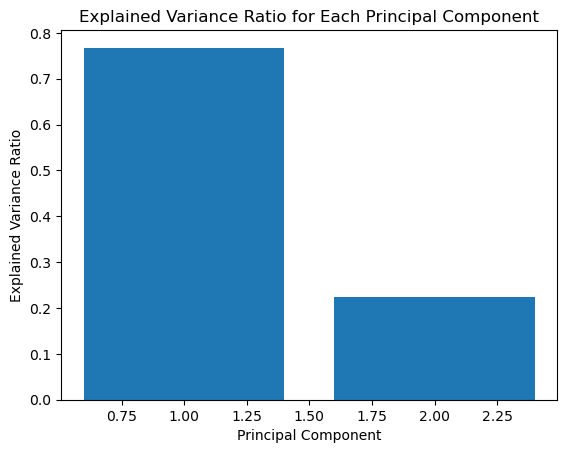

In [1007]:
plt.bar(range(1, n_components + 1), explained_variance_ratio)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio for Each Principal Component')
plt.show()